# Fit spatiotemporal receptive fields for remapping dataset with pyglmnet

## Imports

In [1]:
import numpy as np
from pyglmnet import GLM
from spykes.strf import STRF
import matplotlib.pyplot as plt
% matplotlib inline
from scipy.io import loadmat, savemat 
import pandas as pd
from tqdm import tqdm
from copy import copy

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Read data file

In [2]:
# probes_df = pd.read_csv('./dataFiles/probes_m15_d2_c27.csv')
# probes_df = pd.read_csv('./dataFiles/probes_m15_d1_c26.csv')
# probes_df = pd.read_csv('./dataFiles/probes_m15_d1v1_c21.csv')
probes_df = pd.read_csv('./dataFiles/probes_m15_d1_c22.csv')
probes_df.head()

,probeNum,fixNum,numSaccs,trialNum,rawTrialNum,rewardedSacc,fixProbe,saccProbe,saccPeakVel,expectedPeakVel,...,x_targ,y_targ,x_dist,y_dist,x_probe,x_curFix,x_oneFixAhead,y_probe,y_curFix,y_oneFixAhead
0,1,1,3,1,2,0,1,0,621.846802,590.037659,...,8.772618,-14.74351,-8.772618,14.74351,-14.743510,-0.408377,-10.101587,-8.656129,0.285779,14.571429
1,2,1,3,1,2,0,1,0,621.846802,590.037659,...,8.772618,-14.74351,-8.772618,14.74351,8.772618,-0.408377,-10.101587,-14.396982,0.285779,14.571429
2,3,1,3,1,2,0,0,1,621.846802,590.037659,...,8.772618,-14.74351,-8.772618,14.74351,-14.743510,-0.408377,-10.101587,2.825576,0.285779,14.571429
3,4,2,3,1,2,0,1,0,660.281372,648.911987,...,8.772618,-14.74351,-8.772618,14.74351,-8.864478,-9.199333,-9.701588,-14.396982,14.659667,-3.995238
4,5,2,3,1,2,0,1,0,660.281372,648.911987,...,8.772618,-14.74351,-8.772618,14.74351,-8.864478,-9.199333,-9.701588,14.307281,14.659667,-3.995238


In [3]:
probes_df.keys()

Index([u'probeNum', u'fixNum', u'numSaccs', u'trialNum', u'rawTrialNum',
       u'rewardedSacc', u'fixProbe', u'saccProbe', u'saccPeakVel',
       u'expectedPeakVel', u't_probe', u't_fix', u't_sacc', u'x_targ',
       u'y_targ', u'x_dist', u'y_dist', u'x_probe', u'x_curFix',
       u'x_oneFixAhead', u'y_probe', u'y_curFix', u'y_oneFixAhead'],
      dtype='object')

In [4]:
probes_df[['t_probe', 't_fix', 't_sacc']][:10]

,t_probe,t_fix,t_sacc
0,17854,17846,18062
1,17973,17846,18062
2,18093,17846,18062
3,18213,18138,18775
4,18334,18138,18775
5,18454,18138,18775
6,18573,18138,18775
7,24720,24712,25283
8,24840,24712,25283
9,24960,24712,25283


In [5]:
# fixations_df = pd.read_csv('./dataFiles/fixations_m15_d2_c27.csv')
# fixations_df = pd.read_csv('./dataFiles/fixations_m15_d1_c26.csv')
# fixations_df = pd.read_csv('./dataFiles/fixations_m15_d1v1_c21.csv')
fixations_df = pd.read_csv('./dataFiles/fixations_m15_d1_c22.csv')
fixations_df.iloc[:9]

,fixNum_f,numSaccs_f,trialNum_f,rawTrialNum_f,rewardedSacc_f,saccPeakVel_f,expectedPeakVel_f,t_fix_f,t_sacc_f,x_targ_f,y_targ_f,x_dist_f,y_dist_f,x_curFix_f,x_oneFixAhead_f,y_curFix_f,y_oneFixAhead_f
0,1,3,1,2,0,621.846802,590.037659,17846,18062,8.772618,-14.743510,-8.772618,14.74351,-0.408377,-10.101587,0.285779,14.571429
1,2,3,1,2,0,660.281372,648.911987,18138,18775,8.772618,-14.743510,-8.772618,14.74351,-9.199333,-9.701588,14.659667,-3.995238
2,3,3,1,2,0,828.264954,791.380005,18861,19077,8.772618,-14.743510,-8.772618,14.74351,-9.703733,10.298412,-3.025023,-15.328571
3,1,10,2,3,0,465.270264,453.821808,24712,25283,20.530682,2.893586,14.651650,-14.74351,-0.534688,-12.568254,0.054558,0.171429
4,2,10,2,3,0,452.605957,465.236237,25355,25602,20.530682,2.893586,14.651650,-14.74351,-12.227523,-12.868255,0.255233,13.004762
5,3,10,2,3,0,152.887039,159.926636,25682,25857,20.530682,2.893586,14.651650,-14.74351,-12.820255,-13.368255,12.581143,16.404762
6,4,10,2,3,0,612.214966,587.915955,25912,26008,20.530682,2.893586,14.651650,-14.74351,-13.287704,-18.534922,16.356501,0.204762
7,5,10,2,3,0,168.395737,179.415161,26086,26279,20.530682,2.893586,14.651650,-14.74351,-17.991571,-20.134920,1.219615,5.138095
8,6,10,2,3,0,695.726929,700.585632,26337,26581,20.530682,2.893586,14.651650,-14.74351,-20.054056,0.531746,5.140415,4.304762


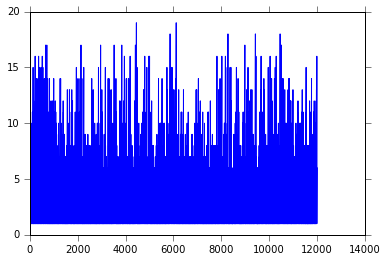

In [6]:
#len(fixations_df)
plt.plot(fixations_df['fixNum_f'])
plt.show()

In [7]:
# spikes_df = pd.read_csv('./dataFiles/spiketimes_m15_d2_c27_u1.csv', header=None)
# spikes_df = pd.read_csv('./dataFiles/spiketimes_m15_d1_c26_u1.csv', header=None)
# spikes_df = pd.read_csv('./dataFiles/spiketimes_m15_d1v1_c21_u1.csv', header=None)
spikes_df = pd.read_csv('./dataFiles/spiketimes_m15_d1_c22_u1.csv', header=None)
spiketimes = np.squeeze(spikes_df.values)
spiketimes.shape

(571897,)

## Define functions

In [8]:
def tikhonov_from_prior(PriorCov):
    """Given a prior covariance matrix, returns a Tikhonov matrix"""
    [U, S, V] = np.linalg.svd(PriorCov, full_matrices=False)

    S_ratio = S / S.max()
    threshold = 0.0001

    nonzero_indices = np.where(S_ratio > threshold)[0]
    zero_indices = np.where(S_ratio <= threshold)[0]

    S_inv = copy(np.sqrt(S))
    S_inv[zero_indices] = threshold
    S_inv[nonzero_indices] = 1. / S_inv[nonzero_indices]

    Tau = np.dot(np.diag(S_inv), V)
    n_features = Tau.shape[0]
    Tau = 1. / n_features * Tau
    return Tau

In [9]:
def build_probeDesignMatrix(fixations_df,probes_df,design_params):

    window=design_params['window']
    binsize=design_params['binsize']
    n_features=design_params['n_features']
    n_zero_bins=design_params['n_zero_bins']
    n_shape=design_params['n_shape']
    
    bin_template = np.arange(window[0], window[1] + binsize, binsize)
    n_bins = len(bin_template) - 1

    probetimes = probes_df['t_probe'].values
    spatial_features = np.zeros((0, n_features))
    spike_counts = np.zeros((0,))
    fixation_id = np.zeros((0,))

    # For each fixation
    for fx in tqdm(fixations_df.index):
 
        # Fixation time
        fixation_time = fixations_df.loc[fx]['t_sacc_f']

        this_fixation_spatial_features = np.zeros((n_bins, n_features))
        this_fixation_spikecounts = np.zeros(n_bins)
        unique_fixation_id = fixations_df.loc[fx]['trialNum_f'] + 0.01 * fixations_df.loc[fx]['fixNum_f']
        this_fixation_id = unique_fixation_id * np.ones(n_bins)

        # Look for probes in window of interest relative to fixation
        probe_ids = np.searchsorted(probetimes,
                                    [fixation_time + window[0] + 0.1,
                                     fixation_time + window[1] - 0.1])
        
        # For each such probe
        for probe_id in range(probe_ids[0], probe_ids[1]):

            # Check if probe lies within spatial region of interest
            fix_row = fixations_df.loc[fx]['y_oneFixAhead_f']
            fix_col = fixations_df.loc[fx]['x_oneFixAhead_f']
            probe_row = probes_df.loc[probe_id]['y_probe']
            probe_col = probes_df.loc[probe_id]['x_probe']

            if ((probe_row - fix_row) > -n_shape / 2 and \
                (probe_row - fix_row) < n_shape / 2 and \
                (probe_col - fix_col) > -n_shape / 2 and \
                (probe_col - fix_col) < n_shape / 2):

                # Get probe timestamp relative to fixation
                probe_time = probes_df.loc[probe_id]['t_probe']
                probe_bin = np.where(bin_template < (probe_time - fixation_time))[0][-1]

                # Define an image based on the relative locations
                I = np.zeros(shape=(n_shape, n_shape))
                row = -np.round(probe_row - fix_row) + n_shape/2 - 1 
                col = np.round(probe_col - fix_col) + n_shape/2 - 1
                I[row, col] = 1

                # Compute projection
                basis_projection = strf_.project_to_spatial_basis(I, spatial_basis)
                this_fixation_spatial_features[probe_bin, :] = basis_projection

        # Count spikes in window of interest relative to fixation
        bins = fixation_time + bin_template
        searchsorted_idx = np.searchsorted(spiketimes,
                                           [fixation_time + window[0],
                                            fixation_time + window[1]])
        this_fixation_spike_counts = np.histogram(spiketimes[searchsorted_idx[0]:
                                                             searchsorted_idx[1]], bins)[0]

        # accumulate
        fixation_id = np.concatenate((fixation_id, this_fixation_id), axis=0)
        spatial_features = np.concatenate((spatial_features, this_fixation_spatial_features), axis=0)
        spike_counts = np.concatenate((spike_counts, this_fixation_spike_counts), axis=0)

        # zero pad
        spatial_features = np.concatenate((spatial_features, np.zeros((n_zero_bins, n_spatial_basis))), axis=0)
        fixation_id = np.concatenate((fixation_id, -999. * np.ones(n_zero_bins)), axis=0)
        
    # Convolve with temporal basis
    features = strf_.convolve_with_temporal_basis(spatial_features, temporal_basis)

    # remove zeropad
    features = features[fixation_id != -999.]   

    return features,spike_counts



## Preprocess data

### Design spatial and temporal basis functions

/Users/danielkentwood/GIT/spykes/spykes/strf.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  gaussian_mask = self.make_2d_gaussian(center=(centers[x],
/Users/danielkentwood/GIT/spykes/spykes/strf.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  centers[y]))


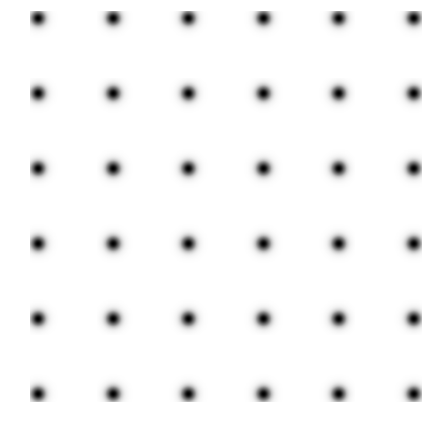

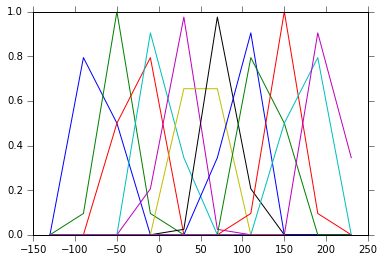

In [10]:
# parameters
time_points = np.linspace(-130., 230., 10.)
centers = [-75.,-50.,-25., 0, 25., 50., 75., 100., 125.,150.,175.,200.]
n_spatial_basis = 36
n_temporal_basis = len(centers)

# build strf
strf_ = STRF(patch_size=50, sigma=5, 
             n_spatial_basis=n_spatial_basis, 
             n_temporal_basis=n_temporal_basis)

# get and visualize spatial basis functions
spatial_basis = strf_.make_gaussian_basis()
strf_.visualize_gaussian_basis(spatial_basis)

# get and visualize temporal basis functions
temporal_basis = strf_.make_raised_cosine_temporal_basis(time_points=time_points, 
                                                         centers=centers,
                                                         widths=25.*np.ones(n_temporal_basis))
plt.plot(time_points, temporal_basis)
plt.show()

### Design matrix parameters

In [11]:
design_params={}
design_params['n_shape']=50
design_params['n_features']=n_spatial_basis
design_params['window']=[-100,100]
design_params['binsize']=20
design_params['n_zero_bins']=np.floor((design_params['window'][1] - design_params['window'][0]) / design_params['binsize'] / 2)

### Build design matrix

In [22]:
# Build design matrix
features,spike_counts = build_probeDesignMatrix(fixations_df.loc[fixations_df.rewardedSacc_f==0,:],probes_df,design_params)


  0%|          | 0/10995 [00:00<?, ?it/s]/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:52: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:72: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
100%|██████████| 10995/10995 [09:18<00:00,  9.41it/s]


In [23]:
print spike_counts.shape
print features.shape

(109950,)
(109950, 432)


In [24]:
spike_counts.min()

0.0

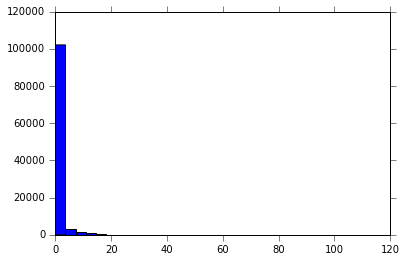

In [25]:
plt.hist(spike_counts, 30)
plt.show()

## Fit Tikhonov regularized GLM

### Design prior covariance matrix

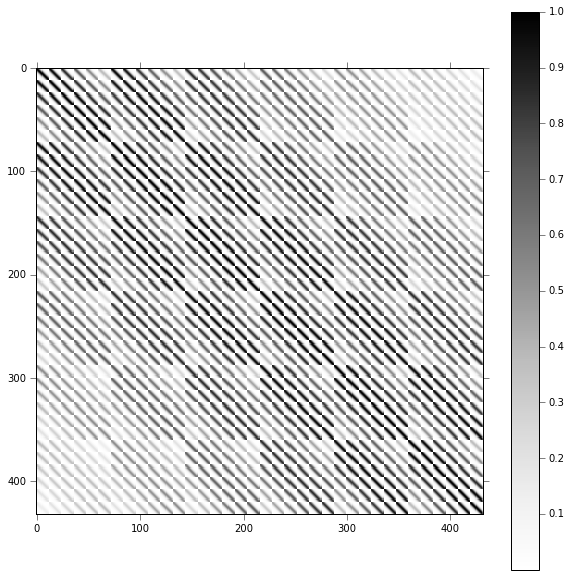

(432, 432)

In [26]:
PriorCov = strf_.design_prior_covariance(sigma_temporal=3., sigma_spatial=5.)

plt.figure(figsize=(10,10))
plt.imshow(PriorCov, cmap='Greys', interpolation='none')
plt.colorbar()
plt.show()

np.shape(PriorCov)

### Fit models

In [27]:
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(features, spike_counts, test_size=0.2, random_state=42)

In [28]:
from pyglmnet import utils
n_samples = Xtrain.shape[0]
Tau = tikhonov_from_prior(PriorCov)

In [29]:
weights = list()
glm_tt = GLM(distr='softplus', alpha=0.,
          reg_lambda=np.logspace(np.log(0.5), np.log(0.01), 10, base=np.exp(1)), 
          Tau=Tau, score_metric='pseudo_R2')
glm_tt.fit(Xtrain, Ytrain)
cvopt_lambda_tt = glm_tt.score(Xtrain, Ytrain).argmax()
print 'tikhonov true'
print '  train GLM score:', glm_tt[cvopt_lambda_tt].score(Xtrain, Ytrain)
print '  test GLM score:', glm_tt[cvopt_lambda_tt].score(Xtest, Ytest)
weights.append(glm_tt[cvopt_lambda_tt].fit_['beta'])


glm_tf = GLM(distr='softplus', alpha=0.,
          reg_lambda=np.logspace(np.log(0.5), np.log(0.01), 10, base=np.exp(1)), 
          Tau=None, score_metric='pseudo_R2')
glm_tf.fit(Xtrain, Ytrain)
cvopt_lambda_tf = glm_tf.score(Xtrain, Ytrain).argmax()
print 'tikhonov false'
print '  train GLM score:', glm_tf[cvopt_lambda_tf].score(Xtrain, Ytrain)
print '  test GLM score:', glm_tf[cvopt_lambda_tf].score(Xtest, Ytest)
weights.append(glm_tf[cvopt_lambda_tf].fit_['beta'])





# models = ['True', 'False']
# weights = list()
# for model_id, tikhonov in enumerate(models):
#     if tikhonov is True:
#         glm = GLM(distr='poisson', alpha=0.,
#                   reg_lambda=np.logspace(np.log(0.5), np.log(0.01), 10, base=np.exp(1)), 
#                   Tau=Tau, score_metric='pseudo_R2')
#     else:
#         glm = GLM(distr='poisson', alpha=0.,
#                   reg_lambda=np.logspace(np.log(0.5), np.log(0.01), 10, base=np.exp(1)), 
#                   Tau=None, score_metric='pseudo_R2')
#     glm.fit(Xtrain, Ytrain)
#     cvopt_lambda = glm.score(Xtest, Ytest).argmax()
#     print 'tikhonov ' + models[model_id]
#     print '  train GLM score:', glm[cvopt_lambda].score(Xtrain, Ytrain)
#     print '  test GLM score:', glm[cvopt_lambda].score(Xtest, Ytest)
#     weights.append(glm[cvopt_lambda].fit_['beta'])

tikhonov true
  train GLM score: -0.000921847695706
  test GLM score: -0.00238062722667
tikhonov false
  train GLM score: -0.00112389245502
  test GLM score: -0.0024875366934


### Visualize

In [30]:
# define the custom colormap

import matplotlib.colors as mcolors

cmap_name = 'my_list'
colors=[(0,(0, 0, 0)), 
        (.75,(.5, .5, .5)), 
        (.85,(1, 1, 1)), 
        (.95,(1, 1, 0)), 
        (1,(1, 0, 0))]

cm = mcolors.LinearSegmentedColormap.from_list(
    cmap_name, colors, N=100)

tikhonov True


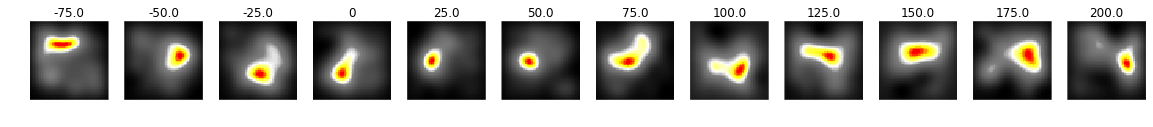

tikhonov False


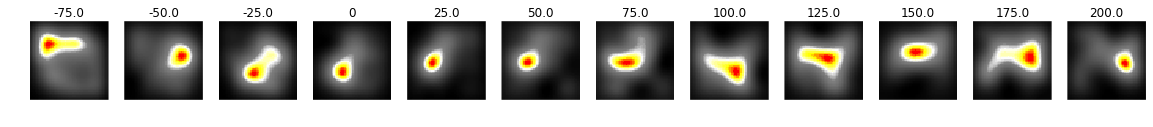

In [31]:
models = ['True', 'False']
for model_id in range(len(weights)):
    print 'tikhonov ' + models[model_id]
    plt.figure(figsize=(20,14))
    for time_bin_ in range(n_temporal_basis):
        RF = strf_.make_image_from_spatial_basis(spatial_basis, 
                                                 weights[model_id][range(time_bin_, 
                                                               n_spatial_basis * n_temporal_basis, 
                                                               n_temporal_basis)])

        plt.subplot(1, n_temporal_basis, time_bin_+1)
        plt.imshow(RF, cmap=cm, interpolation='none')
        titletext = str(centers[time_bin_])
        plt.title(titletext)
        plt.axis('off')
    plt.show()